<a href="https://colab.research.google.com/github/shehriar41891/Stable_Diffusion/blob/Classification%2FVisionTransformers/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python --version

Python 3.10.12


In [1]:
import torch

torch.__version__

'2.4.1+cu121'

In [2]:
torch.cuda.is_available()

True

# Kaggle Setup

In [8]:
from google.colab import files
files.upload()  # Select kaggle.json

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"shehriaralikhan","key":"bd7a45c1c0ae433e9dc301bd8f3af45e"}'}

In [11]:
# Make a directory for the kaggle.json file
os.makedirs('/root/.kaggle/', exist_ok=True)

# Move the kaggle.json file to the appropriate directory
!mv /content/kaggle.json  /root/.kaggle/

# Set permissions for the file
!chmod 600 /root/.kaggle/kaggle.json

# Verify that the setup was successful by listing Kaggle datasets
!kaggle datasets list


ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                        Student Performance Factors                          94KB  2024-09-02 10:53:57          26492        463  1.0              
abdulszz/spotify-most-streamed-songs                           Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14           9853        127  1.0              
ironwolf404/electric-vehicle-population-in-usa                 Electric Vehicle Population in USA                    6MB  2024-10-05 12:06:02           1027         31  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset    Mo

In [14]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 337M/346M [00:09<00:00, 26.5MB/s]
100% 346M/346M [00:09<00:00, 37.5MB/s]


In [15]:
!unzip /content/intel-image-classification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/seg_train/seg_train/mountain/7662.jpg  
  inflating: /content/seg_train/seg_train/mountain/767.jpg  
  inflating: /content/seg_train/seg_train/mountain/7672.jpg  
  inflating: /conten

# Loading Train and Test Data

In [5]:
from torchvision import datasets,transforms
from torch.utils.data import  DataLoader

In [17]:
import os
NUM_WORKERS = os.cpu_count() #it set the number of cpu layers we got for parallel execuation


def create_dataloader(
  train_dir : str,
  test_dir : str,
  transform : transforms.Compose, # Transformations to apply to the data (e.g., resizing, normalization)
  batch_size : int,
  num_workers : int = NUM_WORKERS #number of cpu core working for loading the data
  ):

  train_data = datasets.ImageFolder(train_dir,transform=transform)
  test_data = datasets.ImageFolder(test_dir,transform=transform)

  class_names = train_data.classes

  #turn images into dataloader
  train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
  )
  test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
  )

  return train_dataloader,test_dataloader,class_names


In [16]:
IMG_SIZE = 224
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

In [18]:
train_dir="/content/seg_train/seg_train"
test_dir="/content/seg_test/seg_test"

In [20]:
BATCH_SIZE = 32
train_dataloader,test_dataloader,class_names = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE
)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7dcdf5f3b2b0>,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

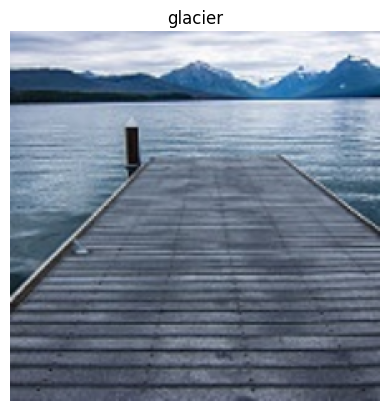

In [30]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Specify the index of the image you want to display
image_index = 9

# Get the class label from `class_names` using the label from the batch
class_label = class_names[label_batch[image_index]]

# Display the image
plt.title(class_label)  # Set the title to the class label
plt.imshow(image_batch[image_index].permute(1, 2, 0))  # Show the image
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


In [28]:
total_batches = len(train_dataloader)
print(f"Total number of batches: {total_batches}")

Total number of batches: 439


In [70]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, embedding_dim,in_channels):
        super(PatchEmbedding, self).__init__()  # Make sure to call the parent class's constructor
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = 3

        # Create a Conv2d layer for patch extraction
        self.patcher = nn.Conv2d(  # Use nn.Conv2d (note the lowercase 'd')
            in_channels=self.in_channels,
            out_channels=self.embedding_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):  # Use forward instead of __call__
        x = self.patcher(x)
        x_flattened = self.flatten(x)
        return x_flattened.permute(0, 2, 1)

In [73]:
patchify = PatchEmbedding(patch_size=16, embedding_dim=768,in_channels=3)

print(f"Input shape: {image_batch.shape}")
print(f"Output shape: {patchify(image_batch).shape}")

Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 196, 768])


# Adding Class and Positional Embeddings

In [54]:
image, label = image_batch[0], label_batch[0]

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4205,  0.2179, -1.2541,  ...,  0.1467,  0.1415,  0.1275],
         [ 0.4184,  0.2215, -1.2574,  ...,  0.1527,  0.1467,  0.1198],
         ...,
         [ 0.3348,  0.1062, -0.9235,  ...,  0.0959,  0.0583,  0.0776],
         [ 0.3718,  0.1764, -0.9523,  ...,  0.1169,  0.0334,  0.1045],
         [ 0.3476,  0.1728, -0.9910,  ...,  0.1250,  0.0992,  0.0837]]],
       grad_fn=<CatBackward0>)


# MultiHead Attention

In [55]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

# MLP Block

In [56]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Transformer Block

In [57]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x


In [62]:
!pip install -q torchinfo

**Summary of Transformer Block**

In [63]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#  Vision transformer

In [74]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

#Train Model

In [75]:
vit = ViT(num_classes=len(class_names))

In [79]:
!pip install -q going_modular

ERROR: Could not find a version that satisfies the requirement going_modular (from versions: none)
ERROR: No matching distribution found for going_modular


In [ ]:
import torch
import torch.nn as nn

# Assuming you have already defined your Vision Transformer model (vit)
# Define your train and test data loaders
# train_dataloader = ...
# test_dataloader = ...

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,  # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999),  # Default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)  # From the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Function to set seeds for reproducibility (if needed)
def set_seeds(seed=42):
    torch.manual_seed(seed)
    # If you're using a GPU, you can set the seed for the CUDA as well
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


# Training loop
def train_model(model, train_loader, test_loader, optimizer, loss_fn, epochs, device):
    model.to(device)  # Move the model to the specified device (CPU or GPU)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch in train_loader:
            # Move the input data to the device
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

        # Optionally, you can evaluate the model on the test set here

# Train the model
train_model(vit, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu')


Epoch [1/10], Loss: 1.8818
Epoch [2/10], Loss: 1.7915
Epoch [3/10], Loss: 1.7914
